<H1>Moving fast</H1>

<H2>The fastest way to calculate a Simple Moving Average in Python</H2>

Today we want to explore the fastest way to calculate a Simple Moving Average in Python. I'm building a crypto trading bot and I want it to be as fast as possible when making decisions to buy or sell. Speed doesn't matter when you are trading one specific coin in the daily timeframe. It starts to matter though when you are trading multiple coins or accounts, in short timeframes, or when you are scanning the whole market for trading opportunities.

<H3>What is a Simple Moving Average and why is it important?</H3>

Almost everybody knows about the Simple Moving Average (SMA) - and its calculation is, well, simple. For instance, with a lookback period of 20, you just take the sum of the values of the previous 20 values and divide it by 20.

The SMA is important for trading not only on its own, but also as a building block for other indicators, or to act as a low-pass filter and smooth out noisy values of other indicators. 

<H3>How do I calculate a Simple Moving Average in Python?</H3>

Until recently, a Pandas dataframe is (or at least was) the central data structure for my bot. Then I started to use Numba to accelerate my backtesting algorithm. That was after I had to accept, that detailed backtesting is path-dependent and cannot be done with vectorized operations. Numba requires the use of loops in many cases, but it can really help to speed them up significantly, but you will see that it still is not always the fastest way to do things.

This is how I got interested in finding the fastest way to calculate a Simple Moving Average in Python. 

My personal focus is on the execution time for arrays (time series) of about 200 and 2,000 values. These are typical lengths for operations that my bot does when running in live mode or for backtesting. But we will run tests for series of up to 1,000,000 values, which can be expected for running backtests for short timeframes (e.g. 5 minute charts) over data from multiple years.

There are several ways we can try here:

    • Use a pure Python approach with or without list comprehension
    • Use Pandas and its integrated 'rolling' function.
    • Use a pure Numpy implementation, although Numpy does not offer (easy) sliding window functionality. 
    • Use Numba with a naive loop-based approach with a sliding window function.
    • Use Numba with a more efficient sliding window function.
    • Use TALib, which is a Python wrapper for the underlying C++ library.
    • Use Bottleneck, a Python package which provides certain enhancements to Numpy, 'movemean' for instance.

Sure, there are more was to do this. I just don't want to make this too long and as you wil later see, there is a good solution and no algorithm using Python or Numpy will be faster than that.

<H3>The code</H3>

At first we need to import the necessary libraries. If you don't have them installed already, you can do so by running 'pip install <package>' from witin your virtual environment. You can also do this by adding '!pip install \<package\>' at the head of the notebook.

In [41]:
import numpy as np
import pandas as pd
import numba as nb
import talib as ta
import bottleneck as bn
import statistics
import numpy.typing as npt
import time

Now we are ready to write some functions that we can later use to compare the different algorithms, their running time, and the results. I omitted the pure Python implementation, because we already know that it would be the slowest approach  

In [42]:
def sma_pp(arr: tuple, n: int) -> list:
    """SMA with naive Python implementation."""
    out = [np.nan] * len(arr)
    
    for i in range(n, len(arr)+1):
        out[i - 1] = statistics.mean((arr[i - n : i]))
    
    return out

def sma_pp_lc(arr: tuple, n: int) -> list:
    """SMA with Python implementation and list comprehension."""
    pad = [np.nan] * (n-1)
    out = [statistics.mean((arr[i - n : i])) for i in range(n, len(arr)+1)]
    
    return pad + out    

def sma_pd(arr: pd.Series, n: int) -> pd.Series:
    """SMA with Pandas"""
    return arr.rolling(n).mean()


def sma_np(arr: np.ndarray, n: int) -> np.ndarray:
    """SMA with Numpy"""
    pad = np.empty((n - 1,), dtype=np.float64)
    pad[:] = np.nan

    return np.concatenate((pad, np.convolve(arr, np.ones(n) / n, mode="valid")))


@nb.njit()
def sma_nb_naive(arr: npt.NDArray, n: np.int32) -> npt.NDArray:
    """SMA with naive Numba implementation"""
    # out = np.full_like(arr, np.nan)
    out = np.full_like(arr, np.nan)

    for i in range(n, arr.shape[0] + 1):
        out[i - 1] = np.mean(arr[i - n : i])

    return out


@nb.njit()
def sma_nb_optimized(arr: npt.NDArray, n: np.int32) -> npt.NDArray:
    """SMA with more efficient Numba implementation"""
    len_arr = len(arr)

    cum_sum = np.full_like(arr, np.nan) # [np.nan] * len_arr
    cum_sum[n - 1] = sum(arr[:n])

    for i in range(n, len_arr):
        cum_sum[i] = cum_sum[i - 1] + arr[i] - arr[i - n]

    return cum_sum / n


def sma_ta(arr: np.ndarray, n: int) -> np.ndarray:
    """SMA with talib"""
    return ta.SMA(arr, timeperiod=n)


def sma_bn(arr: np.ndarray, n: int) -> np.ndarray:
    """SMA with Bottleneck"""
    return bn.move_mean(arr, n)

In the next step, more columns are added to the dataframe. They contain the results from the different implementations, so we can be certain that they actually retun the same results.

In [43]:
window_size = 10
close = np.random.rand(100,)
data = pd.DataFrame(data=close, columns=["close"])

data['sma_pp'] = sma_pp(tuple(close), window_size)
data['sma_pp_lc'] = sma_pp_lc(tuple(close), window_size)
data["sma_pd"] = sma_pd(data.close, window_size)
data["sma_np"] = sma_np(close, window_size)
data["sma_nb"] = sma_nb_naive(close, window_size)
data["sma_nb_fst"] = sma_nb_optimized(close, window_size)
data["sma_ta"] = sma_ta(close, window_size)
data["sma_bn"] = sma_bn(close, window_size)

data.head(15)

,close,sma_pp,sma_pp_lc,sma_pd,sma_np,sma_nb,sma_nb_fst,sma_ta,sma_bn
0,0.073936,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.195684,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.432888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.634740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.455457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.488567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.752986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.101944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.846745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.602322,0.458527,0.458527,0.458527,0.458527,0.458527,0.458527,0.458527,0.458527


<H4>How fast will it be?</H4>

Now we're ready to test the speed of the different implementations. They are tested in a loop with different array lengths. The array is a simulation of a time series and random values are good enough for what we're doing here.

We start with a short series and work our way up to 1,000,000 values. This is much more than we have in usual backtest for a trading strategy (except when you choose the 1 minute timeframe - but who does this anyway? Right?) 

I didn't test for different SMA periods and went with a value of 30 here. The length of this lookback value probably has some influence on the speed of the functions, though. 

In [44]:
do_runs = 10_000 # the number of runs to perform
window = 30 # the lookback window for the SMA
arr_lengths = (
    100, 250, 500, 750, 1_000, 2_500, 5_000, 7_500, 10_000, 
    25_000, 50_000, 75_000, 100_000, 250_000, 500_000, 750_000, 
    1_000_000, 2_500_000, 5_000_000, 7_500_000, 10_000_000
)

bench = pd.DataFrame(
    columns=[
        "no_of_values", "pandas", "numpy", "numba_naive",
        "numba_optimized", "talib", "bottleneck",
    ]
)

# a wrapper function to conveniently calculate the avg time needed 
# for one iteration of a given function 
def time_it(func, data, window) -> float:
    # adjust the number of runs based on the amount of data to save some time
    runs = do_runs if len(data) <= 1_000 else do_runs // (len(data) // 2_000) 
    
    start = time.time()
    [func(data, window) for _ in range(runs)]
    
    return float(((time.time() - start) / runs) * 1_000_000) # average and convert to µs

# build a a dataframe with all results from the times measured
# for the different implementations with array lengths
for idx, arr_len in enumerate(arr_lengths):
    window = 50
    
    # construct an array and a dataframe to simulate close prices or 
    # any other time series 
    close = np.random.rand(arr_len,)
    data = pd.DataFrame(data=close, columns=["close"])

    # test each function with current array length and write the 
    # result (execution time) in a cell
    bench.at[idx, "no_of_values"] = arr_len
    # bench.at[idx, "python"] = time_it(sma_pp, tuple(close), window)
    # bench.at[idx, "python_lc"] = time_it(sma_pp, tuple(close), window)
    bench.at[idx, "pandas"] = time_it(sma_pd, data.close, window)
    bench.at[idx, "numpy"] = time_it(sma_np, close, window)
    bench.at[idx, "numba_naive"] = time_it(sma_nb_naive, close, window)
    bench.at[idx, "numba_optimized"] = time_it(sma_nb_optimized, close, window)
    bench.at[idx, "talib"] = time_it(sma_ta, close, window)
    bench.at[idx, "bottleneck"] = time_it(sma_bn, close, window)
    
    bench["speed_gain_pandas"] = pd.Series(np.divide(bench.pandas, bench.bottleneck))
    bench["speed_gain_numpy"] = pd.Series(np.divide(bench.numpy, bench.bottleneck))

# highlight the lowest value in each row
# def highlight_lowest(s):
def highlight_lowest(row, excluded_columns=[]):
    lowest_value = row.drop(excluded_columns).min()
    return ['color: green' if x == lowest_value else '' for x in row]

excluded_columns = ['speed_gain_pandas', 'speed_gain_numpy']
styled_df = bench.style.apply(
    lambda row: highlight_lowest(row, excluded_columns=excluded_columns), 
    axis=1
)

def highlight_columns(column, columns: list):
    if column._name in columns:
        return ['color: blue' for x in column]
    else:
        return ['' for x in column]

styled_df.apply(lambda x: highlight_columns(x, excluded_columns), axis=0)

# format numbers
styled_df.format(
    {
        'no_of_values': '{:,.0f}',
        'python': '{:,.2f}',
        'python_lc': '{:,.2f}',
        'pandas': '{:,.2f}',
        'numpy': '{:,.2f}',
        'numba_naive': '{:,.2f}',
        'numba_optimized': '{:,.2f}',
        'talib': '{:,.2f}',
        'bottleneck': '{:,.2f}',
        'speed_gain_pandas': '{:,.2f}',
        'speed_gain_numpy': '{:,.2f}',
    }
).hide_index()

styled_df

/var/folders/zd/fzwfvnk155zgpfdr2csg9psh0000gn/T/ipykernel_18067/3386626621.py:90: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  ).hide_index()


no_of_values,pandas,numpy,numba_naive,numba_optimized,talib,bottleneck,speed_gain_pandas,speed_gain_numpy
100,87.53,9.42,2.18,1.42,1.47,0.76,115.18,12.40
250,83.20,12.92,6.07,2.34,1.86,0.89,93.21,14.48
500,87.04,18.01,11.46,3.45,2.62,1.34,65.17,13.48
750,81.19,22.22,17.31,4.66,3.01,1.50,54.11,14.81
"1,000",97.15,27.13,22.99,5.75,3.67,1.79,54.31,15.17
"2,500",99.34,58.44,59.07,14.00,8.18,4.36,22.78,13.40
"5,000",154.86,111.42,117.60,29.98,17.38,8.10,19.13,13.76
"7,500",154.91,154.49,174.68,39.53,20.53,13.06,11.86,11.83
"10,000",167.48,203.02,232.58,50.81,24.70,11.95,14.02,17.00
"25,000",331.62,497.38,580.30,122.74,60.58,28.56,11.61,17.41


<H4>The results</H4> 

Well, let's not even talk about the Python implementations. They are orders of magnitude (~30-2000x) slower than everything else, and it doesn't matter if a list comprehension is used or not. I didn't even include them in the final speed test, because they slowed it down so significantly. It took about 8ms for a time series with 200 values and about 100ms for one with 2000 values on my Macbook Air (M1) to calculate the SMA.

The Pandas implementation is quite fast, but it suffers from the overhead of converting the Pandas Series before doing the calculations. It's pretty slow with short series/arrays, but is more efficient with larger arrays. 

I've added the columns 'speed_gain_pandas' and 'speed_gain_numpy' to better be able to compare the fastest solution with the two standard solutions. Notice how the disadvantage of using Pandas is diminishing significantly the bigger the array/series is! 

The Numpy implementation is (of course) faster than Pandas, it only is slower with larger arrays. This was surprising to me.

The Numba variants look pretty good with short arrays, but can't compete with Pandas or Numpy for larger arrays. In fact, they lose the race and are very slow when you have a lot of data. Most surprisingly, the algorithm that I considered to be optimized is the worst of them all, and the naive algorithm is much better.

Ta-lib is written in C and highly optimized for all kinds of indicators, including the Simple Moving Average. It comes in second, no matter how long the array is. 

I have highlighted to lowest (fastest) values for each row in the dataframe. You can see that all the highlighted values are in the Bottleneck column. Bottleneck is even 2-3x faster than ta-lib for the SMA and therefore the clear winner here. 

For small arrays (up to 250-300 values), the time it needs to calculate the SMA ist below 1µs (then we talk about nanoseconds, 1 billionth of one second) and that with Python - amazing! That means that it would take about 1 millisecond to get the SMA for 1,000 assets, and 1 second to get it for 1,000,000 assets. 

For me this means that it is possible to scan all trading pairs on an exchange for trading opportunities in a few seconds. Which is why I'm so obsessed with making my bot faster.

Overall, Bottleneck - the fastest approach - is about 10,000x faster than pure Python for 200 values and  about 3,000x faster for 2000 values.

It's always easier to interpret results with a visual representation. So, let's plot them! Please note, that the y-axis is in log format!

<Axes: xlabel='length of time series', ylabel='execution time in microseconds'>

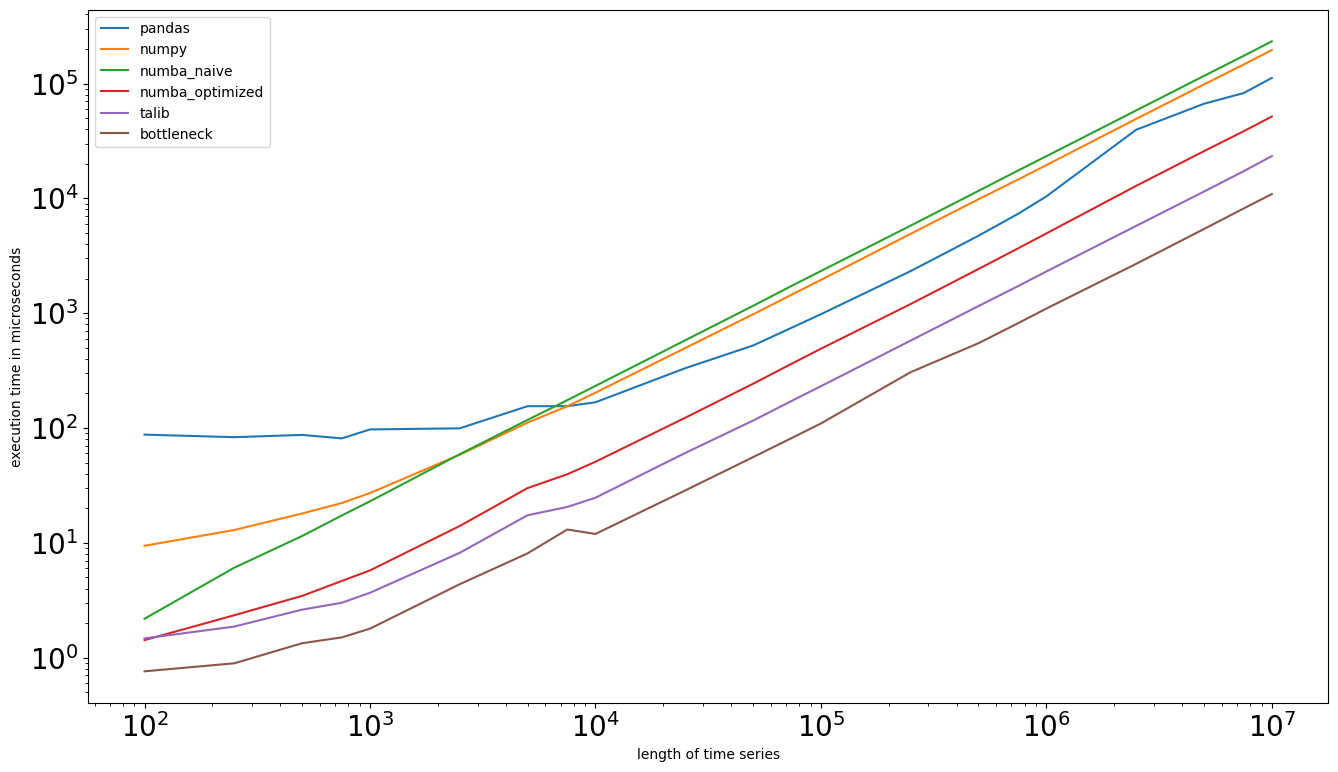

In [45]:
bench.set_index('no_of_values', inplace=True)
bench.drop(columns=['speed_gain_pandas', 'speed_gain_numpy'], inplace=True)
bench.plot(
    xlabel='length of time series', ylabel='execution time in microseconds', 
    logx=True, logy=True, figsize=(16, 9), fontsize=20,
)

<H4>Conclusion</H4>

In this article I took you in on my journey to find the fastest way to calculate the Simple Moving Average with Python. We found that the fastest way to do it is by using Bottleneck, provided that you are working with Pandas or Numpy data anyway. I like that, because it means that there is no need to struggle with Numba or implementing your own algorithms. It's super-fast and it's super-easy! Perfect!